In [275]:
import contextlib
import dataclasses

import numpy
import torch

from contexttimer import Timer
from matplotlib import pyplot
from more_itertools.recipes import pairwise
from typing import Collection, NamedTuple, Tuple, Union

In [276]:
@dataclasses.dataclass(frozen=True)
class Batch:
    """Represent a batch of tasks, returned by `generate_sinusoid_batch`."""
    
    x: numpy.ndarray  # (batch_size_meta, batch_size_inner)
    y: numpy.ndarray  # (batch_size_meta, batch_size_inner)
    amplitude: numpy.ndarray  # (batch_size_meta,)
    phase: numpy.ndarray  # (batch_size_meta,)
    input_range: Tuple[float, float]
    amplitude_range: Tuple[float, float]
        
    def __len__(self):
        return self.x.shape[1]
        
    def __getitem__(self, slice_):
        """Slice over `batch_size_inner`."""
        return Batch(
            self.x[:, slice_],
            self.y[:, slice_],
            self.amplitude,
            self.phase,
            self.input_range,
            self.amplitude_range
        )


def generate_sinusoid_batch(
        batch_size_meta: int,
        batch_size_inner: int,
        amplitude_range: Tuple[float, float] = (0.1, 5.0),
        phase_range: Tuple[float, float] = (0., numpy.pi),
        input_range: Tuple[float, float] = (-5.0, 5.0)) -> Batch:
    """Compute a batch of samples.
    
    We draw `batch_size_meta` tasks, and for each task a batch of `batch_size_inner` points. Each "task"
    represents a regression problem, underlied by a sine wave with some amplitude and phase.
    
    Args:
        batch_size_meta: The number of tasks to draw.
        batch_size_inner: The number of samples for each task.
        amplitude_range: Draw the amplitude of the sine wave for the task uniformly from this range.
        phase_range: Draw the phase of the sine wave for the task uniformly from this range.
        input_range: The range from which the input variable will be drawn uniformly.
    """
    amplitude = numpy.random.uniform(amplitude_range[0], amplitude_range[1], batch_size_meta)
    phase = numpy.random.uniform(phase_range[0], phase_range[1], batch_size_meta)
    
    # All input locations are independent.
    x = numpy.random.uniform(
        input_range[0],
        input_range[1],
        (batch_size_meta, batch_size_inner))
    
    # To compute the outputs, we should broadcast the amplitude & phase over all inner samples.
    y = numpy.expand_dims(amplitude, axis=1) * numpy.sin(x - numpy.expand_dims(phase, axis=1))
    
    return Batch(x, y, amplitude, phase, input_range, amplitude_range)


def plot_task(batch: Batch, index: int):
    """Plot the task with the specified `index` from the given `batch`."""
    # Plot the reference curve
    truth_x = numpy.linspace(batch.input_range[0], batch.input_range[1], 200)
    truth_y = batch.amplitude[index] * numpy.sin(truth_x - batch.phase[index])
    pyplot.plot(truth_x, truth_y, c='r', label='truth')
    
    # Plot the sample points.
    pyplot.plot(batch.x[index], batch.y[index], '^', label='samples')
    
    pyplot.xlim(*batch.input_range)
    max_y = max(batch.amplitude_range)
    pyplot.ylim(-max_y, max_y)
    
    pyplot.legend()

In [277]:
batch = generate_sinusoid_batch(3, 5)

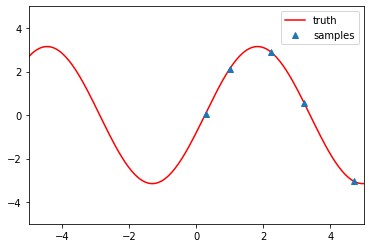

In [278]:
plot_task(batch, 0)

In [279]:
batch.x

array([[ 0.99536483,  2.2299763 ,  4.70289719,  3.21569457,  0.27551067],
       [-1.6852327 , -1.46017804, -4.20969699,  0.5591438 , -3.34205537],
       [-2.04762169,  3.40608485, -1.37437991, -1.59186022,  2.10401744]])

In [305]:
class SinusoidalRegressor(torch.nn.Module):
    """A module suitable for producing  """
    
    def __init__(self, hidden_sizes: Collection[int] = (40, 40)):  
        super().__init__()
        dim_in = 1
        dim_out = 1
        all_dims = (dim_in,) + tuple(hidden_sizes) + (dim_out,)
        self.layers = [torch.nn.Linear(dim_1, dim_2) for dim_1, dim_2 in pairwise(all_dims)]
        
        for i, layer in enumerate(self.layers):
            # In the reference implementation, initialisation is:
            #    * zero for bias terms
            #    * truncated_normal, std=0.01 for weights.
            torch.nn.init.zeros_(layer.bias)
            # TODO truncated normal not available...
            torch.nn.init.xavier_normal_(layer.weight)
            
            # Register this as a sub-module, so we declare the existence of the necessary parameters
            self.add_module(f'layer_{i}', layer)
            
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        for i, layer in enumerate(self.layers):
            x = layer(x)
            
            # We should not apply the non-linearity on the last layer!
            is_last = i == len(self.layers) - 1
            if not is_last:
                x = self.relu(x)
        return x

In [306]:
def get_device():
    """Standard device on which to run computations."""
    return torch.device('cuda:1')

In [307]:
# From code:
batch_size_meta = 25

# The inner batch size. It seems to vary between plots.
# We actually generate *twice* this amount of data in total; half is used for the inner
# training loop, and the other half for inner testing.
batch_size_inner = 10

learning_rate_meta = 0.001  # Meta Adam optimizer
learning_rate_update = 0.001  # Inner Adam optimizer
num_steps_train_meta = 70000

In [308]:
@contextlib.contextmanager
def model_eval(model):
    """Enter 'evaluation mode' for the given model. """
    model.eval()  # DANGER: This *mutates* the model. It returns a reference to itself
    try:
        yield
    finally:
        model.train()

In [309]:
def _module_device(module):
    """Find the pytorch device to which the given module is bound."""
    devices = {x.device for x in module.parameters()}
    if len(devices) != 1:
        raise ValueError(f"Found candidate devices {devices}")
    return next(iter(devices))


def _train_step(module, train_batch: Batch, optimizer):
    device = _module_device(module)
    train_x = torch.tensor(train_batch.x.ravel(), dtype=torch.float32).unsqueeze(1).to(device)
    train_y = torch.tensor(train_batch.y.ravel(), dtype=torch.float32).unsqueeze(1).to(device)

    mse_loss = torch.nn.MSELoss()
    
    # Forward pass: Compute predicted y by passing x to the model
    train_y_pred = module(train_x)

    # Compute loss.
    loss = mse_loss(train_y_pred, train_y)

    # Zero gradients, perform a backward pass (compute gradients wrt. the loss), and update the 
    # weights accordingly.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
class BatchPrediction(NamedTuple):
    y: numpy.ndarray
    mse_loss: float


def _get_test_prediction(module, test_batch: Batch) -> BatchPrediction:
    """Get the prediction when evaluating the module on the given batch."""
    device = _module_device(module)
    test_x = torch.tensor(test_batch.x.ravel(), dtype=torch.float32).unsqueeze(1).to(device)
    test_y = torch.tensor(test_batch.y.ravel(), dtype=torch.float32).unsqueeze(1).to(device)

    mse_loss = torch.nn.MSELoss()
    
    # No need to accumulate gradients when evaluating the validation loss.
    # Also, we put the model into "evaluation mode" for the purpose of computing the prediction.
    # This is to prevent layers like BatchNorm / Dropout mutating their internal state.
    with torch.no_grad(), model_eval(module):
        test_y_pred = module(test_x)
        test_mse = mse_loss(test_y_pred, test_y).item()
        
    return BatchPrediction(test_y_pred.cpu().numpy().squeeze(1), test_mse)

In [310]:
def pretrain_example(
        *,
        num_steps_train: int = 70000,
        batch_size_meta: int = 25,
        batch_size_inner: int = 10,
        learning_rate: float = 0.001,
        verbose: bool = False) -> list:
    device = get_device()
    module = SinusoidalRegressor().to(device)
    
    if verbose:
        print(module)

    # Construct an Optimizer. The call to model.parameters() in the constructor will contain the
    # learnable parameters of the module.
    optimizer = torch.optim.Adam(module.parameters(), lr=learning_rate)
    
    # These are the MSEs from the 'test' part of the batches drawn within the meta-training process.
    meta_train_test_mses = []

    numpy.random.seed(42)
    
    with Timer() as timer:
        for i_meta in range(num_steps_train):
            
            # Generate a batch with which to train.
            batch = generate_sinusoid_batch(batch_size_meta, batch_size_inner * 2)
            
            train_batch = batch[:batch_size_inner]
            test_batch = batch[batch_size_inner:]
            
            _train_step(module, train_batch, optimizer)

            if i_meta % 500 == 0:
                prediction = _get_test_prediction(module, test_batch)
                meta_train_test_mses.append(prediction.mse_loss)
                if verbose:
                    print(f'Epoch {i_meta + 1}/{num_steps_train}:   {prediction.mse_loss}')

    print(timer)
    
    return meta_train_test_mses, module

In [ ]:
meta_train_test_mses, module = pretrain_example()

In [ ]:
pyplot.plot(meta_train_test_mses)

In [ ]:
def meta_test(
        module,
        *,
        batch_size_inner: int = 10,
        learning_rate: float = 0.001):
    """Perform a single test on the trained module"""
    # FIXME We need to make an independent copy of the module's parameters before we mutate them in training.
    batch = generate_sinusoid_batch(1, 2 * batch_size_inner)
    train_batch = batch[:batch_size_inner]
    test_batch = batch[batch_size_inner:]
    
    prediction = _get_test_prediction(module, test_batch)
    plot_task(train_batch, 0)
    pyplot.plot(test_batch.x[0], prediction.y, '<')
    pyplot.show()
    
    optimizer = torch.optim.Adam(module.parameters(), lr=learning_rate)
    
    _train_step(module, train_batch, optimizer)
    #TODO Evaluate over a much finer grid to make a better plot
    prediction = _get_test_prediction(module, test_batch)
    plot_task(train_batch, 0)
    pyplot.plot(test_batch.x[0], prediction.y, '<')
    print(prediction.y)
    pyplot.show()
    
    for _ in range(29):
        _train_step(module, train_batch, optimizer)
    prediction = _get_test_prediction(module, test_batch)
    plot_task(train_batch, 0)
    pyplot.plot(test_batch.x[0], prediction.y, '<')
    print(prediction.y)
    pyplot.show()
    

    

In [ ]:
numpy.random.seed(33)
meta_test(module)

In [ ]:
module(torch.from_numpy(numpy.expand_dims(numpy.array([-3, -2, -1, 0, 4], dtype=numpy.float32), 1)).to(get_device()))

In [ ]:
list(module.parameters())